[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D4_ClimateResponse-Extremes&Variability/W2D4_Tutorial5.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W2D4_ClimateResponse-Extremes&Variability/W2D4_Tutorial5.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 5: Non-stationarity in Historical Records**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Yosemley Bermúdez, Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorial Objectives**

In this tutorial, we will analyze the annual maximum sea level heights in Washington DC. Coastal storms, particularly when combined with high tides, can result in exceptionally high sea levels, posing significant challenges for coastal cities. Understanding the magnitude of extreme events, such as the X-year storm, is crucial for implementing effective safety measures. We will examine the annual maximum sea level data from a measurement station near Washington DC.

By the end of this tutorial, you will gain the following abilities:

- Analyze timeseries data during different climate normal periods.
- Evaluate changes in statistical moments and parameter values over time to identify non-stationarity.

# **Setup**

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
from scipy import stats
from scipy.stats import genextreme as gev
import os
import pooch
import tempfile

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [3]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [4]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W2D4_ClimateResponse-Extremes&Variability' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1**
Let's inspect the annual maximum sea surface height data and create a plot over time. 

In [5]:
# download file: 'WashingtonDCSSH1930-2022.csv'

filename_WashingtonDCSSH1='WashingtonDCSSH1930-2022.csv'
url_WashingtonDCSSH1 = "https://osf.io/4zynp/download"

data = pd.read_csv(pooch_load(url_WashingtonDCSSH1,filename_WashingtonDCSSH1), index_col=0).set_index('years')

SHA256 hash of downloaded file: d1725e1e5c6ccd7561644771c9ad17ab07e553c05b4156a38cb6780aaca36edb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [6]:
data

,ssh
years,
1931,-140
1932,-112
1933,-6
1934,-51
1935,-94
...,...
2018,517
2019,299
2020,257


<Axes: xlabel='years', ylabel='Annual Maximum Sea Surface Height (mm)'>

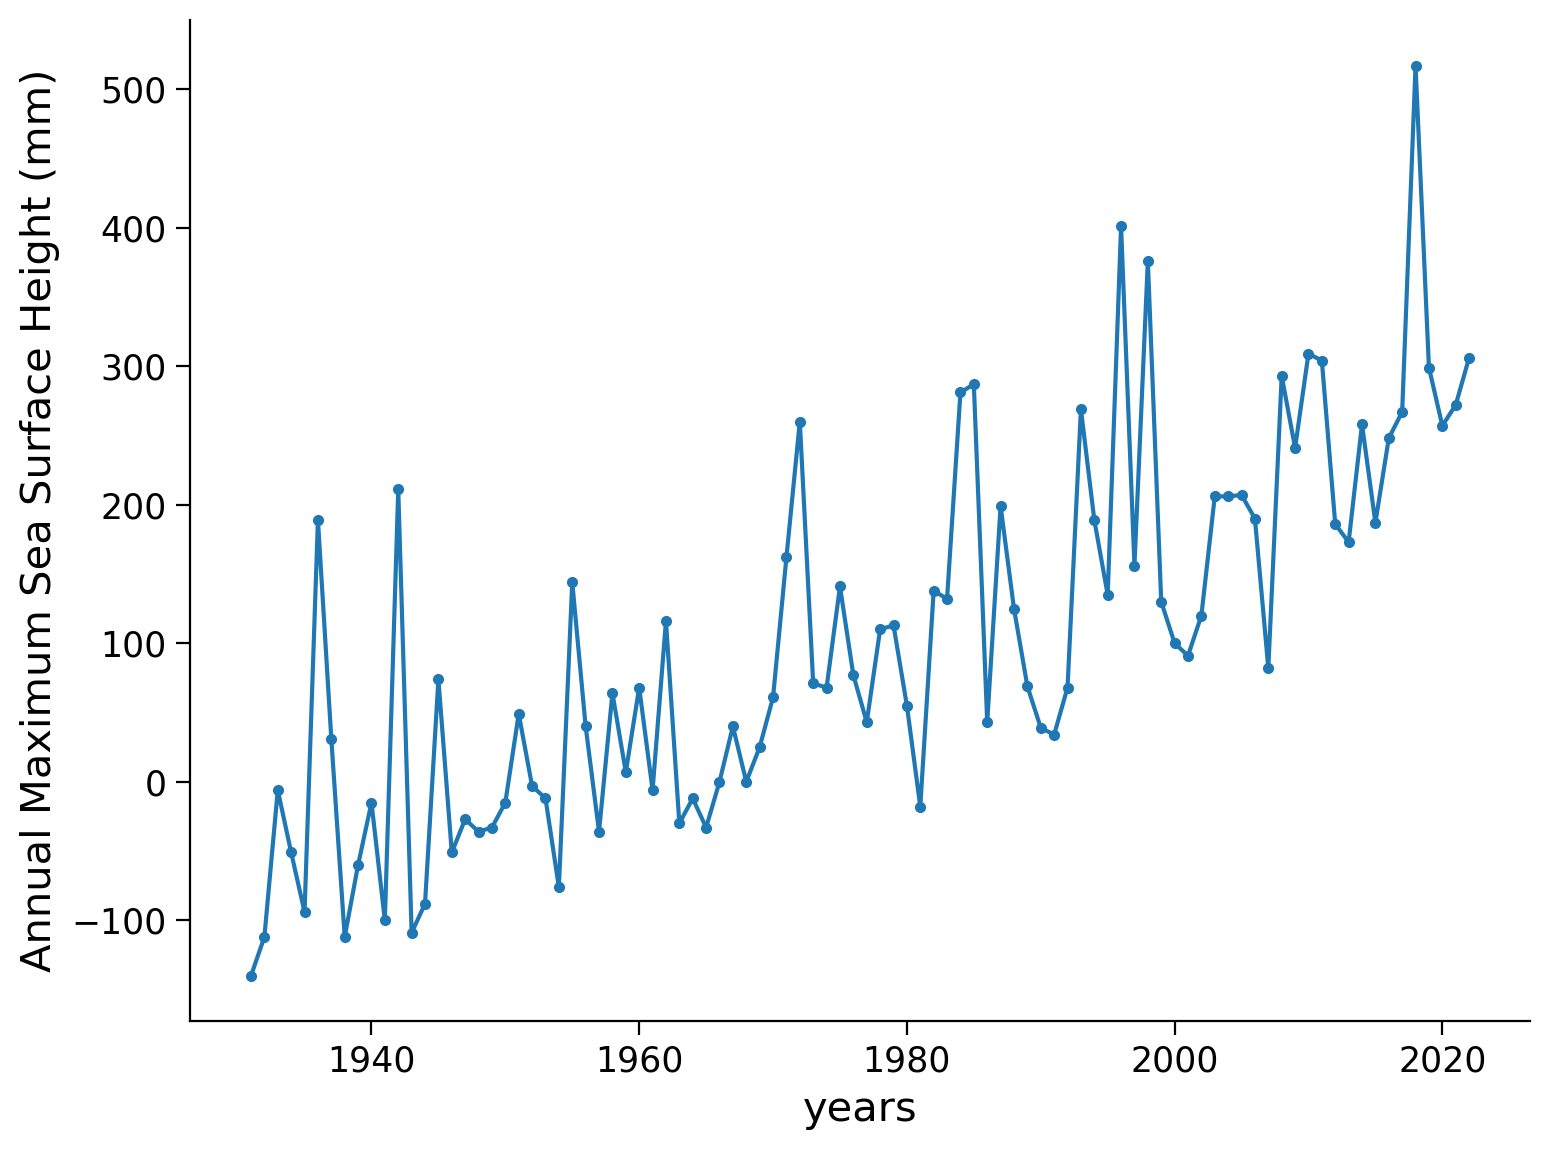

In [7]:
data.ssh.plot(linestyle='-',marker='.',ylabel='Annual Maximum Sea Surface Height (mm)')


Take a close look at the plot of your recorded data. There appears to be an increasing trend, which can be attributed to the rising sea surface temperatures caused by climate change. In this case, the trend seems to follow a linear pattern. It is important to consider this non-stationarity when analyzing the data.

In previous tutorials, we assumed that the probability density function (PDF) shape remains constant over time. In other words, the precipitation values are derived from the same distribution regardless of the timeframe. However, in today's world heavily influenced by climate change, we cannot assume that the PDF remains stable. For instance, global temperatures are increasing, causing a shift in the distribution's location. Additionally, local precipitation patterns are becoming more variable, leading to a widening of the distribution. Moreover, extreme events are becoming more severe, resulting in thicker tails of the distribution. We refer to this phenomenon as **non-stationarity**.

To further investigate this, we can group our data into three 30-year periods known as "**climate normals**". We can create one record for the period from 1931 to 1960, another for 1961 to 1990, and a third for 1991 to 2020. By plotting the histograms of each dataset within the same frame, we can gain a more comprehensive understanding of the changes over time.


In [8]:
# 1931-1960
data_period1 = data.iloc[0:30]
# 1961-1990
data_period2 = data.iloc[30:60]
# 1990-2020
data_period3 = data.iloc[60:90]

Text(0.5, 0, 'Annual Maximum Sea Surface Height (mm)')

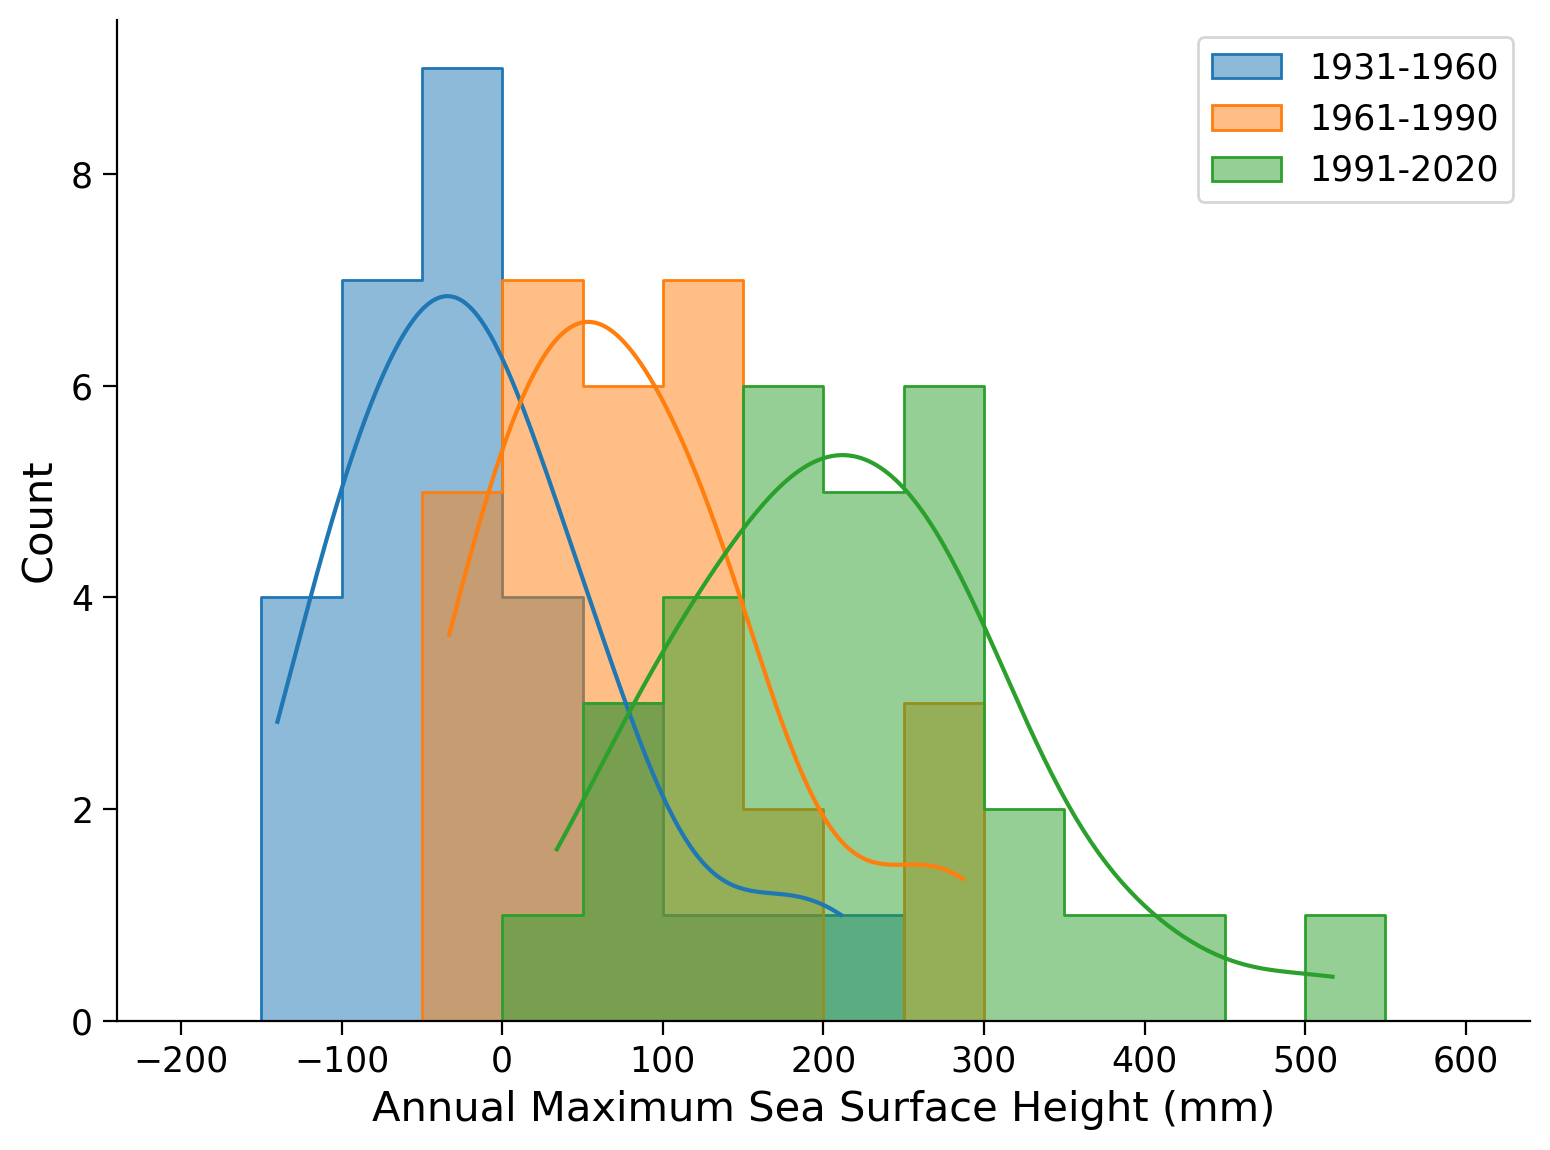

In [9]:
# plot the histograms for each climate normal identified above
fig,ax=plt.subplots()
sns.histplot(data_period1.ssh,bins=np.arange(-200,650,50),color='C0',element='step',alpha=0.5,kde=True,label='1931-1960',ax=ax)
sns.histplot(data_period2.ssh,bins=np.arange(-200,650,50),color='C1',element='step',alpha=0.5,kde=True,label='1961-1990',ax=ax)
sns.histplot(data_period3.ssh,bins=np.arange(-200,650,50),color='C2',element='step',alpha=0.5,kde=True,label='1991-2020',ax=ax)
ax.legend()
ax.set_xlabel('Annual Maximum Sea Surface Height (mm)')

Let's also calculate the moments each climate normal period:

In [10]:
# setup pandas dataframe
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])

# add info for each climate normal period
periods_stats['1931-1960'] = [data_period1.ssh.mean(), data_period1.ssh.std(), data_period1.ssh.skew()]
periods_stats['1961-1990'] = [data_period2.ssh.mean(), data_period2.ssh.std(), data_period2.ssh.skew()]
periods_stats['1991-2020'] = [data_period3.ssh.mean(), data_period3.ssh.std(), data_period3.ssh.skew()]

periods_stats = periods_stats.T
periods_stats

,Mean,Standard Deviation,Skew
1931-1960,-9.966667,87.095066,0.922327
1961-1990,85.200000,87.953906,0.854553
1991-2020,216.633333,105.739264,0.701258


The mean increases as well as the standard deviation. Conversely, the skewness remains relatively stable over time, just decreasing slightly. This observation indicates that the dataset is non-stationary. To visualize the overall shape of the distribution changes, we can fit a Generalized Extreme Value (GEV) distribution to the data for each time period and plot the corresponding probability density function (PDF).

In [11]:
# 1931-1960
params_period1 = gev.fit(data_period1.ssh.values,0)
shape_period1, loc_period1, scale_period1 = params_period1

# 1961-1990
params_period2 = gev.fit(data_period2.ssh.values,0)
shape_period2, loc_period2, scale_period2 = params_period2

# 1991-2020
params_period3 = gev.fit(data_period3.ssh.values,0)
shape_period3, loc_period3, scale_period3 = params_period3

Text(0, 0.5, 'Density')

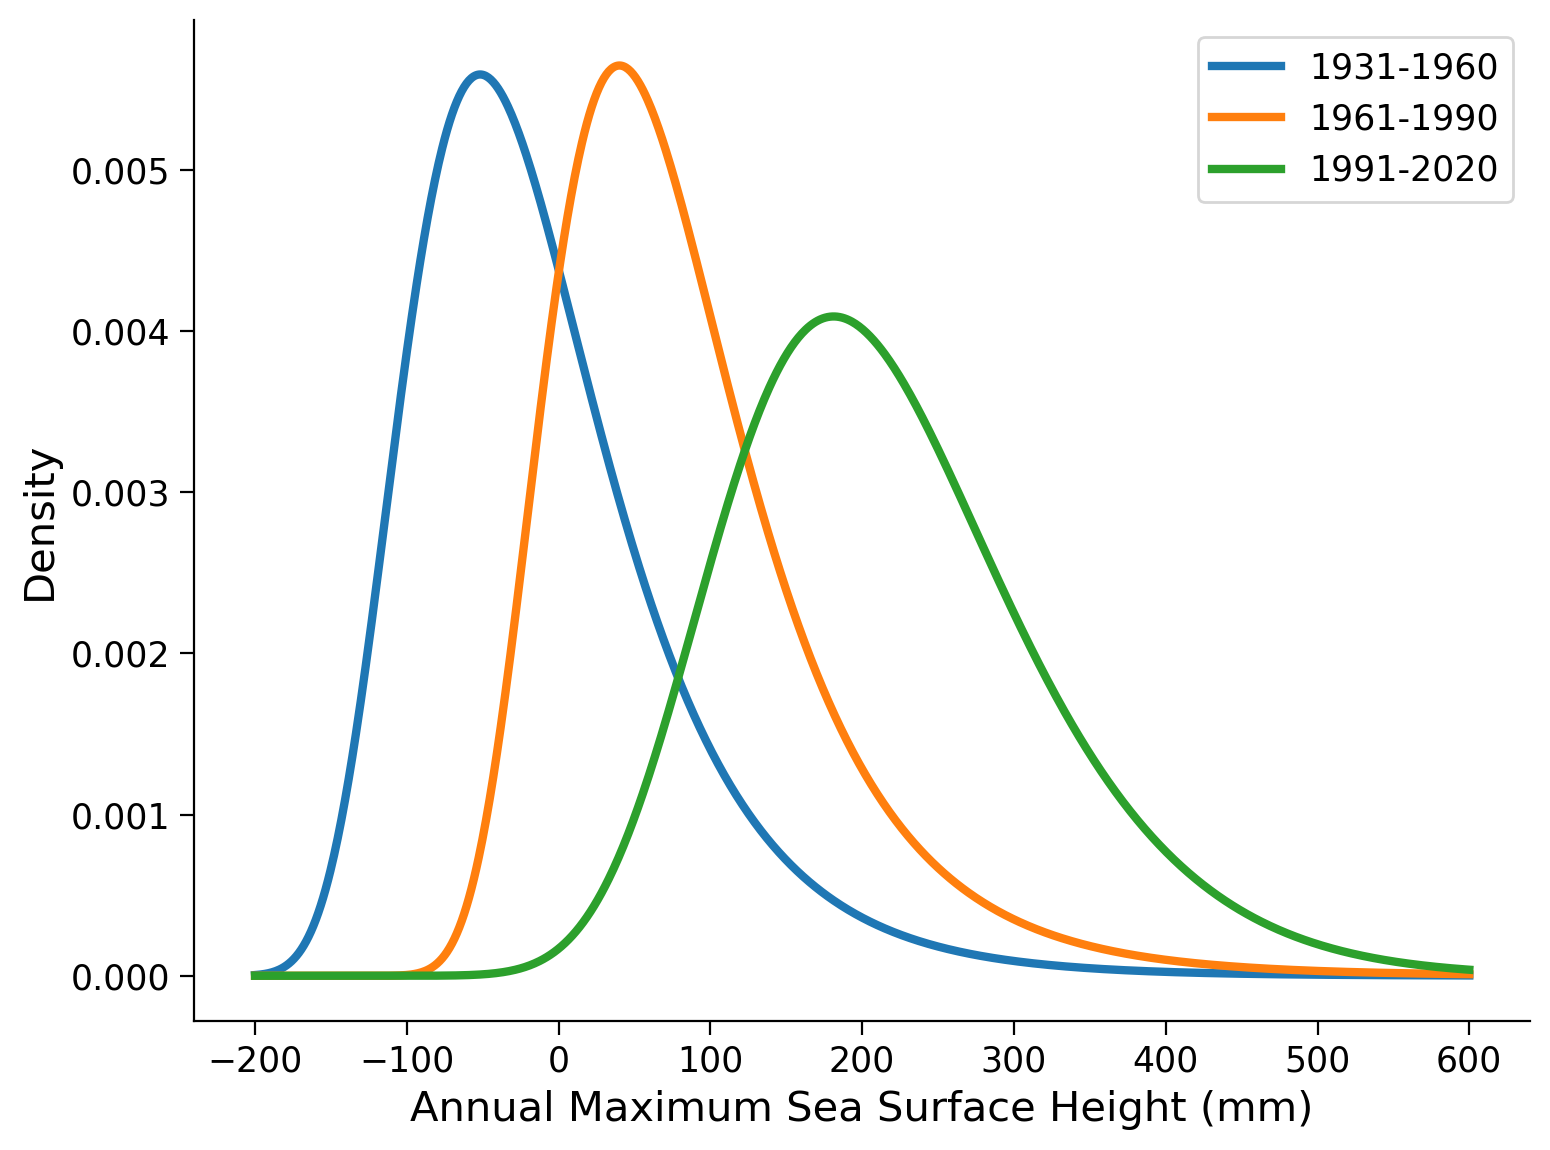

In [12]:
# plot PDFs for each time period

fig, ax = plt.subplots()
x = np.linspace(-200,600,1000)
ax.plot(x,gev.pdf(
    x,shape_period1,
    loc=loc_period1,scale=scale_period1
    ),
    c='C0',lw=3,label='1931-1960')
ax.plot(x,gev.pdf(
    x,shape_period2,
    loc=loc_period2,scale=scale_period2
    ),
    c='C1',lw=3,label='1961-1990')
ax.plot(x,gev.pdf(
    x,shape_period3,
    loc=loc_period3,scale=scale_period3
    ),
    c='C2',lw=3,label='1991-2020')
ax.legend()
ax.set_xlabel('Annual Maximum Sea Surface Height (mm)')
ax.set_ylabel('Density')

Now, let's examine the changes in the GEV parameters. This analysis will provide valuable insights into how we can incorporate non-stationarity into our model in one of the upcoming tutorials.

## **Question 1**

1. Look at the plot above. Just by visual inspection, describe how the distribution changes between time periods. Which parameters of the GEV dsitribution do you think are responsible? How and why? 

In [ ]:
# to_remove explanation
"""
1. There is a relatively large increase int he location parameter over time, and the scale parameter from 1961-1990 and 1991-2020 also increases. This is likely due to sea level rise and also the variability about the mean increasing. The shape parameter also increases over this time but as commented in the lecture this parameter is not usually reliably estimated from such a short time span.
""";

## **Coding Exercise 1** 

1. Compare the location, scale and shape parameters of the fitted distribution for the three time periods. How do they change? Compare with your answers to the question above.

In [ ]:
# setup dataframe with titles for each parameter
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])

# add in 1931-1960 parameters
parameters['1931-1960'] = ...

# add in 1961-1990 parameters
parameters['1961-1990'] = ...

# add in 1991-202 parameters
parameters['1991-2020'] = ...

# transpose the dataset so the time periods are rows
parameters = ...

# round the values for viewing
...

In [13]:
# to_remove solution

# setup dataframe with titles for each parameter
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])

# add in 1931-1960 parameters
parameters['1931-1960'] = [loc_period1, scale_period1, shape_period1]

# add in 1961-1990 parameters
parameters['1961-1990'] = [loc_period2, scale_period2, shape_period2]

# add in 1991-202 parameters
parameters['1991-2020'] = [loc_period3, scale_period3, shape_period3]

# transpose the dataset so the time periods are rows
parameters = parameters.T

# round the values for viewing
parameters.round(4)#.astype('%.2f')

,Location,Scale,Shape
1931-1960,-49.9676,65.7963,-0.0270
1961-1990,43.6207,65.2252,-0.0560
1991-2020,172.2630,90.3313,0.0946


# **Summary**
In this tutorial, you focused on the analysis of annual maximum sea surface heights in Washington DC, specifically considering the impact of **non-stationarity** due to climate change. You've learned how to analyze time series data across different climate normal periods, and how to evaluate changes in statistical moments and parameter values over time to identify this non-stationarity. By segmenting our data into 30-year "**climate normals**" periods, we were able to compare changes in sea level trends over time and understand the increasing severity of extreme events. 

# **Resources**

Original data from this tutorial can be found [here](https://climexp.knmi.nl/getsealev.cgi?id=someone@somewhere&WMO=360&STATION=WASHINGTON_DC&extraargs=). Note the data used in this tutorial were preprocessed to extract the annual maximum values.